# Install 

In [44]:
! pip install memory_profiler
%load_ext memory_profiler 

Defaulting to user installation because normal site-packages is not writeable
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Import 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn  # Speeds up sklearn with intel patch
patch_sklearn()  # Activate patch - changes sklearn imports below

from timeit import default_timer as timer # Time how long commands take
from sklearn.model_selection import train_test_split, StratifiedKFold  # test_train split, cross-validation

from sklearn.experimental import enable_iterative_imputer  # Iterative imputer experimental so need to enable it
from sklearn.impute import IterativeImputer  # Once enabled iterative imputer can be imported

from sklearn.linear_model import RidgeClassifier, BayesianRidge  # Imputation
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder  # Normalisation & Encoding
from imblearn.under_sampling import TomekLinks, RandomUnderSampler   # Undersampling
from imblearn.over_sampling import SMOTENC  # Oversampling
from sklearn.feature_selection import RFE, RFECV  # Recursive feature elimination - feature selection
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier  # RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import validation_curve

from yellowbrick.model_selection import ValidationCurve

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


ModuleNotFoundError: No module named 'yellowbrick'

# Random State

In [3]:
random_state=14

# General Functions

In [4]:
# Stopwatch to profile function runtimes
class Stopwatch:

    # Initiate constructor
    def __init__(self):
        self.start = timer()
        self.end = None
        self.runtime = None

    # Stop stopwatch
    def stop(self):
        self.end = timer()
        self.runtime = self.end - self.start
        return self.runtime

# Data Cleaning

In [5]:
# Read in data
df = pd.read_csv('/data/home/bt211037/dissertation/supervised_ML_data.tsv',
                   sep='\t', header=0, index_col=0)


### Test Train Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'thyroid_cancer'],
                                                        df['thyroid_cancer'],
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=random_state,
                                                        stratify=df['thyroid_cancer'])



### Convert categorical columns to integers

In [7]:
# Find which columns are categorical and which continuous
def cat_con_cols(df):
    
    columns = [list(df[i]) for i in df]  # Nested list of column values
    num_unique_vals = [len(set([i for i in a if pd.notna(i)])) for a in columns]  # Num of unique values in a column

    categorical_indexes = [i for i, v in enumerate(num_unique_vals) if v <= 100
                           and set([a % 1 for a in df[df.columns[i]].dropna()]) == {0}]

    continuous_indexes = [i for i, v in enumerate(num_unique_vals) if v > 100 or
                          set([a % 1 for a in df[df.columns[i]].dropna()]) != {0}]

    cat = list(df.columns[categorical_indexes])
    con = list(df.columns[continuous_indexes])
    return cat, con


In [8]:
# Get the column names of the continuous and categorical data
cat, con = cat_con_cols(X_train)  

# Convert categorical cols values from floats to integers 
X_train[cat] = X_train[cat].astype('Int64')  
X_test[cat] = X_test[cat].astype('Int64')  



### Separate categorical and Continuous features in dataframe¶

This makes indexing certain features in later processess easier. Continuous features are the first columns followed by categorical.


In [9]:
X_train = pd.concat([X_train[con], X_train[cat]], axis=1, join="inner")

# Pipeline

In [10]:
# Column indexes for categorical and continuous features
categorical_indexes = [i for i, x in enumerate(X_train.columns) if x in cat]
continuous_indexes = [i for i, x in enumerate(X_train.columns) if x in con]



In [11]:
# Model used for RFE
model = ExtraTreesClassifier(n_estimators=100, n_jobs=10, 
                             random_state=random_state)


In [12]:
# Five fold stratified cross validation for RFE
skf = StratifiedKFold(n_splits=5)


In [13]:
# Tomek Links undersampling
tl = TomekLinks(sampling_strategy='majority')

In [14]:
# SMOTE oversampling
smote = SMOTENC(random_state=random_state,
                categorical_features=categorical_indexes,
                sampling_strategy=1)


In [15]:
# Multiple imputation with iterative imputer
imputer = ColumnTransformer(
    transformers=[
        ('num', IterativeImputer(initial_strategy='median',
                                 max_iter=5,
                                 random_state=random_state), 
         continuous_indexes),
        
        ('cat', IterativeImputer(estimator=RidgeClassifier(),
                                 initial_strategy='most_frequent',
                                 max_iter=10, 
                                 random_state=random_state), 
         categorical_indexes)
    
    ])


In [16]:
# Simple imputation 
simp_imputer = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(missing_values=np.nan, strategy='mean'),
             continuous_indexes),

            ('cat', SimpleImputer(missing_values=np.nan, strategy='constant',
                                  fill_value=4444),
             categorical_indexes)

        ])


In [17]:
# Recursive Feature Elimination
rfe = RFE(model, step=25)

In [18]:
# Preprocessing pipeline
pipeline = imbpipeline(steps = [('imputer', simp_imputer),
                                ('tomek', tl),
                                ('smotenc', smote),
                                ('rfe', rfe),
                                ('model', model)])

# Undersampling

Undersample the majority class in the dataset to provide a smaller dataset for hyperparamter tuning. Training on this smaller dataset even seems to give better results than on the full dataset.

Reduces the data from ~300,000 to ~55,000 rows/samples.

In [19]:
# Configure random undersampler
rus = RandomUnderSampler(sampling_strategy=0.01,
                         random_state=random_state)


In [20]:
# Create the dataset used for hyperparamter tuning and training
X_res, y_res = rus.fit_resample(X_train, y_train)


In [21]:
X_res

,Waist circumference|x48_0_0,Hip circumference|x49_0_0,Standing height|x50_0_0,Time since interview start at which blood pressure screen(s) shown|x96_0_0,Pulse rate automated reading|x102_0_0,Place of birth in UK - north co-ordinate|x129_0_0,Place of birth in UK - east co-ordinate|x130_0_0,Townsend deprivation index at recruitment|x189_0_0,Length of time at current address|x699_0_0,Duration of walks|x874_0_0,...,Genotype measurement batch|x22000_0_0,Genetic sex|x22001_0_0,Genetic kinship to other participants|x22021_0_0,IPAQ activity group|x22032_0_0,Summed days activity|x22033_0_0,Above moderate/vigorous recommendation|x22035_0_0,Above moderate/vigorous/walking recommendation|x22036_0_0,Close to major road|x24014_0_0,Total volume of urine samples held by UKB|x30394_0_0,medication_cbi
0,79.0,99.0,163.1,144.0,89.0,564500.0,425500.0,1.441460,12.0,15.0,...,1,0,1,0,12,0,1,0,5100,-1
1,87.0,90.0,174.0,94.0,69.0,188500.0,514500.0,-0.688732,25.0,100.0,...,0,1,0,0,4,0,1,0,5100,-1
2,68.0,101.0,155.0,138.0,54.0,336500.0,452500.0,-3.168330,28.0,60.0,...,1,0,0,2,19,1,1,0,5100,-1
3,68.0,99.0,159.0,51.0,58.0,388500.0,327500.0,-4.493780,31.0,45.0,...,1,0,0,1,16,1,1,0,5100,-1
4,92.0,102.0,166.0,54.0,65.0,393500.0,381500.0,-2.409450,24.0,30.0,...,1,0,0,2,18,1,1,0,5100,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,69.0,89.0,160.0,68.0,65.0,172500.0,534500.0,0.577263,59.0,60.0,...,1,0,1,2,16,1,1,0,5100,-1
55445,68.0,90.0,158.0,101.0,65.0,523500.0,446500.0,-4.338350,19.0,30.0,...,1,0,1,2,12,1,1,0,5100,-1
55446,75.0,88.0,158.0,77.0,74.0,401500.0,386500.0,-3.787730,6.0,240.0,...,1,0,0,<NA>,<NA>,<NA>,<NA>,1,5100,1
55447,60.0,88.0,153.0,53.0,67.0,181500.0,534500.0,-2.833990,1.0,NaN,...,1,0,0,<NA>,<NA>,<NA>,<NA>,0,5100,-1


# Hyperparameter Tuning

Below is a test/example hyperparameter tuning run, the final tuning was conducted using the HPC. In this pipeline simpleimputer is used to decrease resource requirements but in the actual run iterative imputation with a different set of paramters was used.

In [44]:
# Parameter to search
search_grid = {'rfe__n_features_to_select':range(20, 380, 25),
               'model__n_estimators': [100, 200, 500],
               'model__max_features': [15],
               'model__max_depth': [5, 10, 15],
               'model__bootstrap': [True, False]}

In [45]:
# Random search configurations
rf_hyper_search = RandomizedSearchCV(estimator=pipeline,
                                    param_distributions=search_grid,
                                    n_iter=10,
                                    cv=3,
                                    n_jobs=10,
                                    verbose=2,
                                    random_state=random_state,
                                    scoring='f1')

In [46]:
%%memit

t=Stopwatch()

rf_hyper_search.fit(X_res, y_res)

print(t.stop())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END model__bootstrap=True, model__max_depth=15, model__max_features=15, model__n_estimators=200, rfe__n_features_to_select=270; total time= 4.9min
[CV] END model__bootstrap=False, model__max_depth=15, model__max_features=15, model__n_estimators=500, rfe__n_features_to_select=220; total time= 6.7min
[CV] END model__bootstrap=False, model__max_depth=15, model__max_features=15, model__n_estimators=200, rfe__n_features_to_select=295; total time= 4.8min
1312.6101462070365
peak memory: 9282.27 MiB, increment: 4816.34 MiB


In [47]:
pd.DataFrame(rf_hyper_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__n_features_to_select,param_model__n_estimators,param_model__max_features,param_model__max_depth,param_model__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,262.229767,20.609423,2.773435,1.254159,320,200,15,15,True,"{'rfe__n_features_to_select': 320, 'model__n_e...",0.016260,0.031930,0.018399,0.022197,0.006938,8
1,379.480125,3.057661,1.166337,0.066027,45,500,15,10,False,"{'rfe__n_features_to_select': 45, 'model__n_es...",0.021239,0.030919,0.023990,0.025383,0.004073,4
2,299.755907,6.011523,2.056729,0.253582,270,200,15,15,True,"{'rfe__n_features_to_select': 270, 'model__n_e...",0.018727,0.029126,0.021739,0.023197,0.004369,7
3,375.812849,17.914864,0.859261,0.537583,145,100,15,5,True,"{'rfe__n_features_to_select': 145, 'model__n_e...",0.027092,0.023386,0.023478,0.024652,0.001726,5
4,395.843006,3.779406,2.875381,0.080597,220,500,15,15,False,"{'rfe__n_features_to_select': 220, 'model__n_e...",0.020202,0.021053,0.022680,0.021312,0.001028,9
5,318.184990,30.075492,1.275600,0.185000,270,200,15,10,True,"{'rfe__n_features_to_select': 270, 'model__n_e...",0.025198,0.024845,0.026628,0.025557,0.000771,2
6,414.959255,27.897383,1.986525,0.606589,145,500,15,15,False,"{'rfe__n_features_to_select': 145, 'model__n_e...",0.019465,0.020833,0.018828,0.019709,0.000836,10
7,411.011822,18.002207,0.969141,0.050492,20,200,15,15,True,"{'rfe__n_features_to_select': 20, 'model__n_es...",0.023256,0.029499,0.024823,0.025859,0.002652,1
8,299.430805,12.347253,2.035716,0.379380,295,200,15,15,False,"{'rfe__n_features_to_select': 295, 'model__n_e...",0.022364,0.023055,0.026104,0.023841,0.001625,6
9,355.587099,8.914181,0.751208,0.354958,145,500,15,10,True,"{'rfe__n_features_to_select': 145, 'model__n_e...",0.022573,0.026532,0.027108,0.025405,0.002016,3


In [49]:
rf_hyper_search.best_params_

{'rfe__n_features_to_select': 20,
 'model__n_estimators': 200,
 'model__max_features': 15,
 'model__max_depth': 15,
 'model__bootstrap': True}

The best configuration here only acheived an f1 score of 0.025 (f1 for positive case, thyroid cancer, predictions) suggesting overfitting, poor hyperparamters or that thyroid cancer cannot be predicted from this data.

# Optimal Model Training

In [22]:
# RFE
rfe_train = RFE(model, step=25, n_features_to_select=20)

In [23]:
rf_train = ExtraTreesClassifier(n_estimators=200, 
                                n_jobs=10, 
                                max_features=15,
                                max_depth=15,
                                bootstrap=True,
                                random_state=random_state)

In [24]:
# Preprocessing pipeline
rfp = imbpipeline(steps = [('imputer', simp_imputer),
                           ('tomek', tl),
                           ('smotenc', smote),
                           ('rfe', rfe_train),
                           ('rf', rf_train)])

### Training - Undersampled Data

In [34]:
%%memit

# Model Training
t=Stopwatch()

rfp.fit(X_res, y_res)

print(t.stop())

183.80418507405557
peak memory: 10812.76 MiB, increment: 4789.06 MiB


In [35]:
# Predictions on the test data
y_preds = rfp.predict(X_test)

In [36]:
# Model evaluation
f1_score(y_test, y_preds)

0.005936319481921209

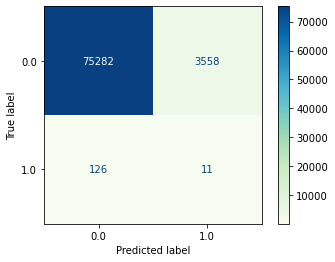

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds, labels=rfp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfp.classes_)
disp.plot(cmap='GnBu')
plt.show()

In [45]:
# Validation curve - max depth vs error



### Training - Full Data

In [29]:
%%memit

# Model Training
t=Stopwatch()

rfp.fit(X_train, y_train)

print(t.stop())

1340.6858474679757
peak memory: 41463.85 MiB, increment: 37844.20 MiB


In [30]:
# Predictions on the test data
y_preds = rfp.predict(X_test)

In [31]:
# Model evaluation
f1_score(y_test, y_preds)

0.006711409395973154

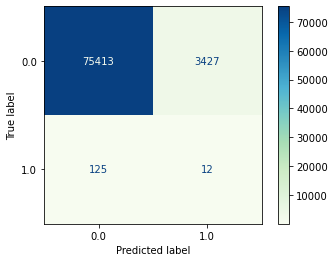

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds, labels=rfp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfp.classes_)
disp.plot(cmap='GnBu')
plt.show()